# Time series forcasting on daily minimal temperatures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as ks
import tensorflow as tf

2023-05-15 12:57:38.624098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 12:57:38.683162: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 12:57:38.684407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 12:57:39.469335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Create function to create time shift series and load data

In [2]:
def tweak_daily_min_temperature(df_, n_timesteps):
    return (df_.assign(Date = lambda df: # date as datetime localized at Melbourne 
                       df.Date.astype('datetime64').dt.tz_localize('Australia/Melbourne')
                      )
            .set_index('Date') # Use date column as index
            # Use time_series_to_supervised_learning function to additionally obtain shifted column of data
            .pipe((time_series_to_supervised_learning, 'df_'), n_shift_back=n_timesteps)
           )

def time_series_to_supervised_learning(df_, n_shift_back=None, n_shift_forward=None, dropna=True):
    '''Function is designed to create new columns of all existing columns of df_. df_is seen as a time series.
    Thus, it is recommended to store all time information in index.
    df_ is time series pandas.Series or pandas.DataFrame
    n_shift_back is integer of how often index should be shiftet backwards. Creating new columns each shift.
    n_shift_forward is integer of how often index should be shiftet forwards. Creating new columns each shift.'''
    # Storing all column labels of initial DataFrame
    cols = df_.columns.values
    # Step through all backward time steps, when some were given
    if n_shift_back != None:
        for i in range(1, n_shift_back + 1):
            # dictionary to store new columns assignments in
            shift_dict = {}
            # step through all columns of initial DataFrame
            for _, col in enumerate(cols):
                # construct name of new (shiftet in time) column
                col_name = col + '(t' + str(-i) + ')'
                # store command to shift column in dictionary and use constructed column name as key
                shift_dict.update({col_name: df_[col].shift(i)})
            df_ = df_.assign(**shift_dict)
            # read colum names, so they can be ordered afterwards
            temporary_cols = list(df_.columns)
            # slice of the new columns assigned to the right of df_ and sort them before all other columns
            new_cols = temporary_cols[-len(cols):] + temporary_cols[:-len(cols)]
            # Reorder columns to new order
            df_ = df_[new_cols]
    if n_shift_forward != None:
        for i in range(1, n_shift_forward+1):
            # dictionary to store new columns assignments in
            shift_dict = {}
            # step through all columns of initial DataFrame
            for _, col in enumerate(cols):
                # construct name of new (shifted in time) column
                col_name = col + '(t+' + str(i) + ')'
                # store command to shift column in dictionary and use constructed column name as key
                shift_dict.update({col_name: df_[col].shift(-i)})
            df_ = df_.assign(**shift_dict)
    # Drop rows with NA, if defined by dropna and return DataFrame                
    if dropna:
        return df_.dropna()
    else:
        return df_

In [115]:
# Load dataset in a pandas DataFrame
df_raw = pd.read_csv('daily-min-temperatures.csv')
# Define number of timesteps
n_timesteps = 6
# Use tweak function to set index to local Melbourne time and add shifted column (y) for supervised learning
df = tweak_daily_min_temperature(df_raw, n_timesteps)

In [116]:
df

,Temp(t-6),Temp(t-5),Temp(t-4),Temp(t-3),Temp(t-2),Temp(t-1),Temp
Date,,,,,,,
1981-01-07 00:00:00+11:00,20.7,17.9,18.8,14.6,15.8,15.8,15.8
1981-01-08 00:00:00+11:00,17.9,18.8,14.6,15.8,15.8,15.8,17.4
1981-01-09 00:00:00+11:00,18.8,14.6,15.8,15.8,15.8,17.4,21.8
1981-01-10 00:00:00+11:00,14.6,15.8,15.8,15.8,17.4,21.8,20.0
1981-01-11 00:00:00+11:00,15.8,15.8,15.8,17.4,21.8,20.0,16.2
...,...,...,...,...,...,...,...
1990-12-27 00:00:00+11:00,13.1,13.2,13.9,10.0,12.9,14.6,14.0
1990-12-28 00:00:00+11:00,13.2,13.9,10.0,12.9,14.6,14.0,13.6
1990-12-29 00:00:00+11:00,13.9,10.0,12.9,14.6,14.0,13.6,13.5


In [117]:
# Scaling
df = df.assign(**{(col + '_scaled'): (df[col] - df[col].min())/
                  (df[col].max() - df[col].min()) for col in df.columns
               }
              )

#df = df.assign(**{(col + '_scaled'): (df[col] - df[col].min())/(df[col].max() - df[col].min()) for col in df.columns

# Split off two datasets to be used as training and evaluation datasets
df_train = df.loc[:'1987-07-29']
df_eval = df.loc['1987-07-30':]


# Create numpy arrays of shape (samples, timesteps, features), where timesteps=1, features=1
# Use unshifted Temperature column as target_values for training, thus predictions won't need to 
# shift in order to allign with 
y_target = df_train['Temp_scaled'].to_numpy().astype(np.float32)[:, np.newaxis, np.newaxis]
x_train = df_train.loc[:, f'Temp(t-{n_timesteps})_scaled':'Temp(t-1)_scaled'].to_numpy().astype(np.float32)[:, :, np.newaxis]
# Similar for evaluation data set, only x-values needed
x_eval = df.loc[:, f'Temp(t-{n_timesteps})_scaled':'Temp(t-1)_scaled'].to_numpy().astype(np.float32)[:, :, np.newaxis]

## Define model and train it

In [118]:
RNN = ks.Sequential()
RNN.add(ks.layers.LSTM(100, input_shape=(n_timesteps, 1), return_sequences=False)) #hidden layer
RNN.add(ks.layers.Dense(1, activation='linear')) # output layer

RNN.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer='adam') 

# List to add up values of loss function during training
history_buffer_loss = []

2023-05-15 14:23:09.207718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 14:23:09.209928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 14:23:09.211570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2023-05-15 14:23:10.846208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 14:23:10.848031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 14:23:10.849542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

75/75 [==============================] - 2s 6ms/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 2/30
75/75 [==============================] - 0s 6ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 3/30
75/75 [==============================] - 1s 7ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 4/30
75/75 [==============================] - 0s 5ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 5/30
75/75 [==============================] - 0s 5ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 6/30
75/75 [==============================] - 0s 5ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 7/30
75/75 [==============================] - 0s 5ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 8/30
75/75 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 9/30
75/75 [==============================] - 0s 6ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 10/30
75/75 [====================

Text(0.5, 0.98, 'Loss function')

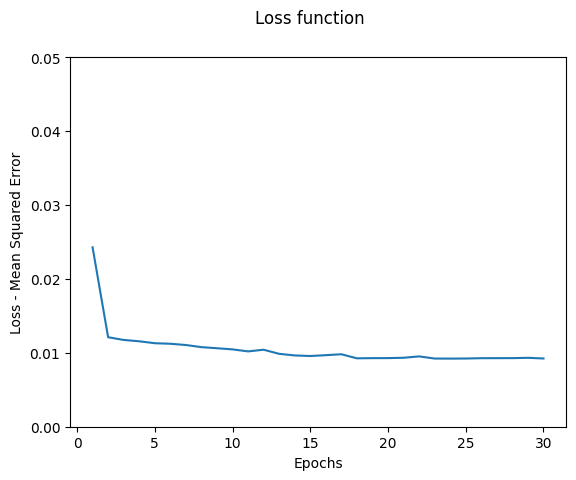

In [119]:
# Fit model on training data
history = RNN.fit(x_train, y_target, batch_size=32, epochs=30)
# Adding up information about loss for each epoch
history_buffer_loss += history.history['loss']

# plotting loss function
fig, ax = plt.subplots()
ax.set_ylim(bottom=0, top=0.05) #top=np.max(history_buffer_loss).round(1) + 0.1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss - Mean Squared Error')
ax.plot(list(range(1, len(history_buffer_loss) + 1)), history_buffer_loss)
fig.suptitle('Loss function')

In [120]:
# Predict on evaluation data set
y_eval_predict = pd.Series(RNN.predict(x_eval)[:, 0].flatten(), index=df.index)
# Back scaling of predicted data
y_eval_predict = (y_eval_predict*(df.Temp.max() - df.Temp.min())) + df.Temp.min()

df = df.assign(Temp_predict=y_eval_predict).fillna(0.0)

  1/114 [..............................] - ETA: 48s

2023-05-15 14:23:41.568685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 14:23:41.570958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 14:23:41.572364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

114/114 [==============================] - 1s 3ms/step


In [72]:
df

,Temp(t-6),Temp(t-5),Temp(t-4),Temp(t-3),Temp(t-2),Temp(t-1),Temp,Temp(t-6)_scaled,Temp(t-5)_scaled,Temp(t-4)_scaled,Temp(t-3)_scaled,Temp(t-2)_scaled,Temp(t-1)_scaled,Temp_scaled,Temp_predict
Date,,,,,,,,,,,,,,,
1981-01-07 00:00:00+11:00,20.7,17.9,18.8,14.6,15.8,15.8,15.8,0.787072,0.680608,0.714829,0.555133,0.600760,0.600760,0.600760,0.579401
1981-01-08 00:00:00+11:00,17.9,18.8,14.6,15.8,15.8,15.8,17.4,0.680608,0.714829,0.555133,0.600760,0.600760,0.600760,0.661597,0.567797
1981-01-09 00:00:00+11:00,18.8,14.6,15.8,15.8,15.8,17.4,21.8,0.714829,0.555133,0.600760,0.600760,0.600760,0.661597,0.828897,0.601115
1981-01-10 00:00:00+11:00,14.6,15.8,15.8,15.8,17.4,21.8,20.0,0.555133,0.600760,0.600760,0.600760,0.661597,0.828897,0.760456,0.696502
1981-01-11 00:00:00+11:00,15.8,15.8,15.8,17.4,21.8,20.0,16.2,0.600760,0.600760,0.600760,0.661597,0.828897,0.760456,0.615970,0.647251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27 00:00:00+11:00,13.1,13.2,13.9,10.0,12.9,14.6,14.0,0.498099,0.501901,0.528517,0.380228,0.490494,0.555133,0.532319,0.494843
1990-12-28 00:00:00+11:00,13.2,13.9,10.0,12.9,14.6,14.0,13.6,0.501901,0.528517,0.380228,0.490494,0.555133,0.532319,0.517110,0.478789
1990-12-29 00:00:00+11:00,13.9,10.0,12.9,14.6,14.0,13.6,13.5,0.528517,0.380228,0.490494,0.555133,0.532319,0.517110,0.513308,0.473849


In [78]:
((df['Temp_predict'].shift(-1) - df['Temp_scaled'])**2).mean()

0.002824076475873022

In [88]:
(x_train[2, :, :], y_target[2, :, :])

(array([[0.7148289 ],
        [0.5551331 ],
        [0.60076046],
        [0.60076046],
        [0.60076046],
        [0.66159695]], dtype=float32),
 array([[0.82889736]], dtype=float32))

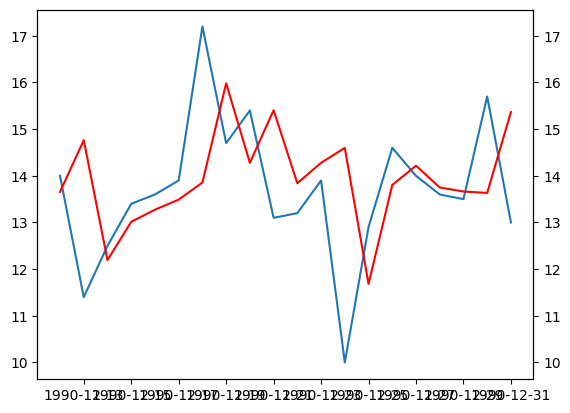

In [121]:
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax2.sharey(ax)

ax.plot(df.iloc[-20:].Temp)
ax2.plot(df.Temp_predict.iloc[-20:], color='red')

In [17]:
df

,Temp(t-1),Temp,Temp(t-1)_scaled,Temp_scaled,Temp_predict
Date,,,,,
1981-01-02 00:00:00+11:00,20.7,17.9,0.787072,0.680608,0.000000
1981-01-03 00:00:00+11:00,17.9,18.8,0.680608,0.714829,0.000000
1981-01-04 00:00:00+11:00,18.8,14.6,0.714829,0.555133,0.000000
1981-01-05 00:00:00+11:00,14.6,15.8,0.555133,0.600760,0.000000
1981-01-06 00:00:00+11:00,15.8,15.8,0.600760,0.600760,0.000000
...,...,...,...,...,...
1990-12-27 00:00:00+11:00,14.6,14.0,0.555133,0.532319,13.773549
1990-12-28 00:00:00+11:00,14.0,13.6,0.532319,0.517110,13.389775
1990-12-29 00:00:00+11:00,13.6,13.5,0.517110,0.513308,13.123060
